Applying literature review 1 approach to our project
# https://www.kaggle.com/erick5/predicting-house-prices-with-machine-learning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
from scipy import stats
from scipy.stats import skew
import lightgbm as lgb
# install lightgbm that is compatible for win64
from scipy.stats.stats import pearsonr
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline
# import xgboost as xgb
# import libxgboost as lxgb
# able to install libxgboost (compatible for win64) but unable to import

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# using colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

In [3]:
df = pd.read_csv("/content/drive/My Drive/2019_hdb_dataset_with_mrt_schools_sm.csv")
# change path if using jupyter notebook
df.drop('Unnamed: 0', axis=1, inplace=True)
df
# 22186 rows × 26 columns

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Year,address,Latitude,Longtitude,Postal,full_address,nearest_mrt,nearest_mrt_distance(km),nearest_primary_school,nearest_primary_school(km),nearest_secondary_school,nearest_secondary_school(km),nearest_JC/MI,nearest_JC/MI(km),nearest_mixed_level,nearest_mixed_level(km),nearest_sm,nearest_sm_distance(km)
0,ANG MO KIO,3 ROOM,01 TO 03,68.0,New Generation,1981,61 years 01 month,270000.0,2019,330 ANG MO KIO AVE 1,1.362432,103.851031,560330,330 ANG MO KIO AVENUE 1 TECK GHEE VIEW SINGAPO...,ANG MO KIO MRT STATION,0.845591,TECK GHEE PRIMARY SCHOOL,0.355873,DEYI SECONDARY SCHOOL,0.552798,EUNOIA JUNIOR COLLEGE,1.173726,CATHOLIC HIGH SCHOOL,1.083775,G8 MART PTE. LTD.,0.391164
1,ANG MO KIO,3 ROOM,04 TO 06,73.0,New Generation,1976,56 years 04 months,295000.0,2019,215 ANG MO KIO AVE 1,1.366558,103.841624,560215,215 ANG MO KIO AVENUE 1 ANG MO KIO 22 SINGAPOR...,ANG MO KIO MRT STATION,0.958109,ANG MO KIO PRIMARY SCHOOL,0.401382,ANG MO KIO SECONDARY SCHOOL,0.140156,EUNOIA JUNIOR COLLEGE,0.471203,CHIJ ST. NICHOLAS GIRLS' SCHOOL,1.136466,NTUC Fairprice Co-operative Ltd,0.000000
2,ANG MO KIO,3 ROOM,07 TO 09,67.0,New Generation,1978,58 years 01 month,270000.0,2019,225 ANG MO KIO AVE 1,1.367396,103.838150,560225,225 ANG MO KIO AVENUE 1 HDB-ANG MO KIO SINGAPO...,ANG MO KIO MRT STATION,1.299709,ANG MO KIO PRIMARY SCHOOL,0.212151,MAYFLOWER SECONDARY SCHOOL,0.319176,EUNOIA JUNIOR COLLEGE,0.605035,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.820483,SHENG SIONG SUPERMARKET PTE LTD,0.157761
3,ANG MO KIO,3 ROOM,01 TO 03,67.0,New Generation,1978,58 years,230000.0,2019,225 ANG MO KIO AVE 1,1.367396,103.838150,560225,225 ANG MO KIO AVENUE 1 HDB-ANG MO KIO SINGAPO...,ANG MO KIO MRT STATION,1.299709,ANG MO KIO PRIMARY SCHOOL,0.212151,MAYFLOWER SECONDARY SCHOOL,0.319176,EUNOIA JUNIOR COLLEGE,0.605035,CHIJ ST. NICHOLAS GIRLS' SCHOOL,0.820483,SHENG SIONG SUPERMARKET PTE LTD,0.157761
4,ANG MO KIO,3 ROOM,01 TO 03,68.0,New Generation,1981,61 years,262500.0,2019,333 ANG MO KIO AVE 1,1.361343,103.851699,560333,333 ANG MO KIO AVENUE 1 TECK GHEE VIEW SINGAPO...,ANG MO KIO MRT STATION,0.979445,TOWNSVILLE PRIMARY SCHOOL,0.297218,DEYI SECONDARY SCHOOL,0.664513,EUNOIA JUNIOR COLLEGE,1.254093,CATHOLIC HIGH SCHOOL,1.044928,G8 MART PTE. LTD.,0.468670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22181,YISHUN,EXECUTIVE,04 TO 06,142.0,Apartment,1988,67 years 07 months,580000.0,2019,326 YISHUN RING RD,1.429551,103.842440,760326,326 YISHUN RING ROAD YISHUN RIVERGREEN SINGAPO...,YISHUN MRT STATION,0.827513,HUAMIN PRIMARY SCHOOL,0.344253,YISHUN TOWN SECONDARY SCHOOL,0.597328,YISHUN INNOVA JUNIOR COLLEGE,1.525837,SINGAPORE SPORTS SCHOOL,5.908707,TAN KWEE ENG,0.057706
22182,YISHUN,EXECUTIVE,07 TO 09,146.0,Maisonette,1988,67 years 07 months,565000.0,2019,326 YISHUN RING RD,1.429551,103.842440,760326,326 YISHUN RING ROAD YISHUN RIVERGREEN SINGAPO...,YISHUN MRT STATION,0.827513,HUAMIN PRIMARY SCHOOL,0.344253,YISHUN TOWN SECONDARY SCHOOL,0.597328,YISHUN INNOVA JUNIOR COLLEGE,1.525837,SINGAPORE SPORTS SCHOOL,5.908707,TAN KWEE ENG,0.057706
22183,YISHUN,EXECUTIVE,01 TO 03,164.0,Apartment,1992,71 years 06 months,633000.0,2019,608 YISHUN ST 61,1.420777,103.835219,760608,608 YISHUN STREET 61 NEE SOON CENTRAL MEADOWS ...,KHATIB MRT STATION,0.450516,NORTHLAND PRIMARY SCHOOL,0.622966,CHUNG CHENG HIGH SCHOOL (YISHUN),0.324133,YISHUN INNOVA JUNIOR COLLEGE,0.752817,SINGAPORE SPORTS SCHOOL,5.132963,KAI SOON SUPERMARKET PTE. LTD.,0.300468
22184,YISHUN,EXECUTIVE,10 TO 12,164.0,Apartment,1992,71 years 06 months,788888.0,2019,604 YISHUN ST 61,1.421713,103.835545,760604,604 YISHUN STREET 61 NEE SOON CENTRAL MEADOWS ...,KHATIB MRT STATION,0.557450,NORTHLAND PRIMARY SCHOOL,0.585734,CHUNG CHENG HIGH SCHOOL (YISHUN),0.382938,YISHUN INNOVA JUNIOR COLLEGE,0.732055,SINGAPORE SPORTS SCHOOL,5.157500,KAI SOON SUPERMARKET PTE. LTD.,0.300015


In [4]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,Year,Latitude,Longtitude,nearest_mrt_distance(km),nearest_primary_school(km),nearest_secondary_school(km),nearest_JC/MI(km),nearest_mixed_level(km),nearest_sm_distance(km)
count,22186.000000,22186.000000,2.218600e+04,22186.0,22186.000000,22186.000000,22186.000000,22186.000000,22186.000000,22186.000000,22186.000000,22186.000000
mean,97.088407,1994.466060,4.321379e+05,2019.0,1.369079,103.836609,0.629066,0.401643,0.510649,2.794488,3.554124,0.319585
std,24.353716,13.216968,1.539757e+05,0.0,0.043908,0.070985,0.387571,0.240960,0.302060,1.470795,2.005528,0.192775
min,31.000000,1966.000000,1.500000e+05,2019.0,1.270380,103.685931,0.026082,0.043539,0.038732,0.131165,0.060566,0.000000
25%,77.000000,1984.000000,3.200000e+05,2019.0,1.338211,103.773996,0.329334,0.225975,0.291738,1.559249,1.711895,0.188447
50%,94.000000,1994.000000,4.000000e+05,2019.0,1.366956,103.843413,0.550915,0.355865,0.449943,2.745469,3.568251,0.287150
75%,112.000000,2004.000000,5.100000e+05,2019.0,1.396934,103.894490,0.841093,0.518162,0.658811,3.912579,5.194514,0.412580
max,192.000000,2016.000000,1.205000e+06,2019.0,1.457071,103.987805,3.515569,3.293312,3.637101,6.903336,9.711738,3.325376


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22186 entries, 0 to 22185
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   town                          22186 non-null  object 
 1   flat_type                     22186 non-null  object 
 2   storey_range                  22186 non-null  object 
 3   floor_area_sqm                22186 non-null  float64
 4   flat_model                    22186 non-null  object 
 5   lease_commence_date           22186 non-null  int64  
 6   remaining_lease               22186 non-null  object 
 7   resale_price                  22186 non-null  float64
 8   Year                          22186 non-null  int64  
 9   address                       22186 non-null  object 
 10  Latitude                      22186 non-null  float64
 11  Longtitude                    22186 non-null  float64
 12  Postal                        22186 non-null  object 
 13  f

In [6]:
# Check for missing values
df.isnull().sum()

town                            0
flat_type                       0
storey_range                    0
floor_area_sqm                  0
flat_model                      0
lease_commence_date             0
remaining_lease                 0
resale_price                    0
Year                            0
address                         0
Latitude                        0
Longtitude                      0
Postal                          0
full_address                    0
nearest_mrt                     0
nearest_mrt_distance(km)        0
nearest_primary_school          0
nearest_primary_school(km)      0
nearest_secondary_school        0
nearest_secondary_school(km)    0
nearest_JC/MI                   0
nearest_JC/MI(km)               0
nearest_mixed_level             0
nearest_mixed_level(km)         0
nearest_sm                      0
nearest_sm_distance(km)         0
dtype: int64


 mu = 432137.91 and sigma = 153972.22



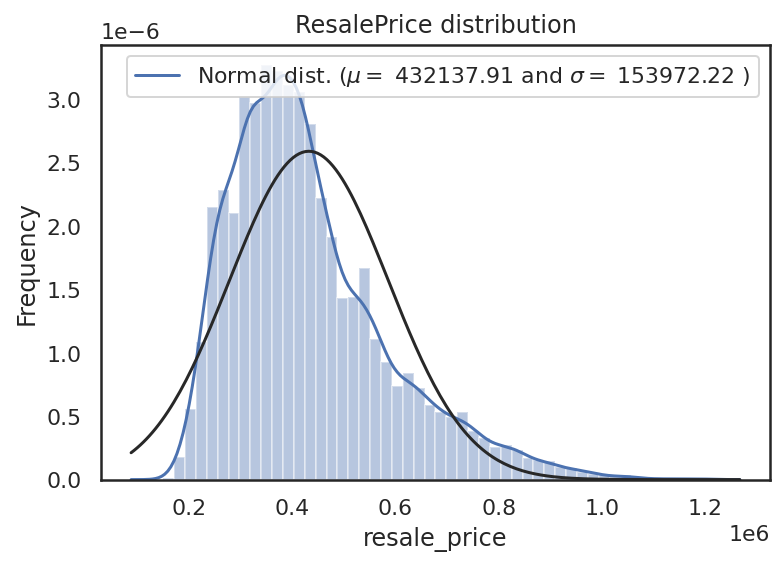

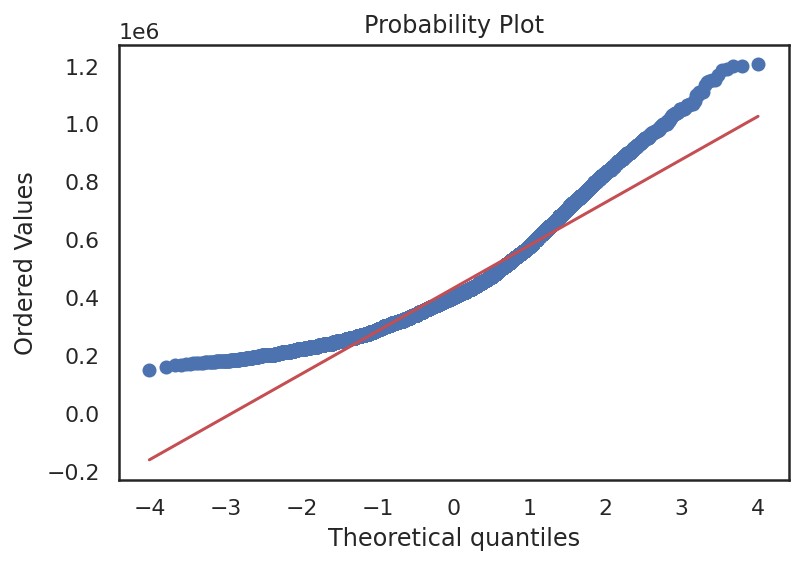

Skewness: 1.103113
Kurtosis: 1.281708


In [7]:
# Check Skewness
import seaborn as sns
sns.distplot(df['resale_price'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['resale_price'])
# mu refers to mean
# sigma refers to standard deviation
# https://www.quora.com/How-do-you-explain-mu-and-sigma-in-statistics-to-a-layman#:~:text=Mu%20is%20the%20arithmetic%20mean,sigma%20to%20mu%2B2*sigma

print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ResalePrice distribution')

fig = plt.figure()
res = stats.probplot(df['resale_price'], plot=plt)
plt.show()

print("Skewness: %f" % df['resale_price'].skew())
print("Kurtosis: %f" % df['resale_price'].kurt())

# Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. 
# That is, data sets with high kurtosis tend to have heavy tails, or outliers. 
# Data sets with low kurtosis tend to have light tails, or lack of outliers. 
# A uniform distribution would be the extreme case.

In [8]:
# Multivariate analysis
# Check categorical data
df.select_dtypes(include=['object']).columns

Index(['town', 'flat_type', 'storey_range', 'flat_model', 'remaining_lease',
       'address', 'Postal', 'full_address', 'nearest_mrt',
       'nearest_primary_school', 'nearest_secondary_school', 'nearest_JC/MI',
       'nearest_mixed_level', 'nearest_sm'],
      dtype='object')

In [9]:
# Check numerical data
df.select_dtypes(include=['int64','float64']).columns

Index(['floor_area_sqm', 'lease_commence_date', 'resale_price', 'Year',
       'Latitude', 'Longtitude', 'nearest_mrt_distance(km)',
       'nearest_primary_school(km)', 'nearest_secondary_school(km)',
       'nearest_JC/MI(km)', 'nearest_mixed_level(km)',
       'nearest_sm_distance(km)'],
      dtype='object')

In [10]:
# Total number of features
cat = len(df.select_dtypes(include=['object']).columns)
num = len(df.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  14 categorical + 12 numerical = 26 features


In [11]:
# Feature Selection
# drop_columns = []
# for categorical_column in df.select_dtypes(include=['object']).columns:
#     drop_columns.append(categorical_column)
drop_columns = ['town','address', 'full_address', 'nearest_mrt',
       'nearest_primary_school', 'nearest_secondary_school', 'nearest_JC/MI',
       'nearest_mixed_level', 'nearest_sm','Latitude', 'Longtitude', 'Year']
df.drop(drop_columns, axis=1, inplace=True)
df.head()

,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,Postal,nearest_mrt_distance(km),nearest_primary_school(km),nearest_secondary_school(km),nearest_JC/MI(km),nearest_mixed_level(km),nearest_sm_distance(km)
0,3 ROOM,01 TO 03,68.0,New Generation,1981,61 years 01 month,270000.0,560330,0.845591,0.355873,0.552798,1.173726,1.083775,0.391164
1,3 ROOM,04 TO 06,73.0,New Generation,1976,56 years 04 months,295000.0,560215,0.958109,0.401382,0.140156,0.471203,1.136466,0.000000
2,3 ROOM,07 TO 09,67.0,New Generation,1978,58 years 01 month,270000.0,560225,1.299709,0.212151,0.319176,0.605035,0.820483,0.157761
3,3 ROOM,01 TO 03,67.0,New Generation,1978,58 years,230000.0,560225,1.299709,0.212151,0.319176,0.605035,0.820483,0.157761
4,3 ROOM,01 TO 03,68.0,New Generation,1981,61 years,262500.0,560333,0.979445,0.297218,0.664513,1.254093,1.044928,0.468670


# Visualise Correlation

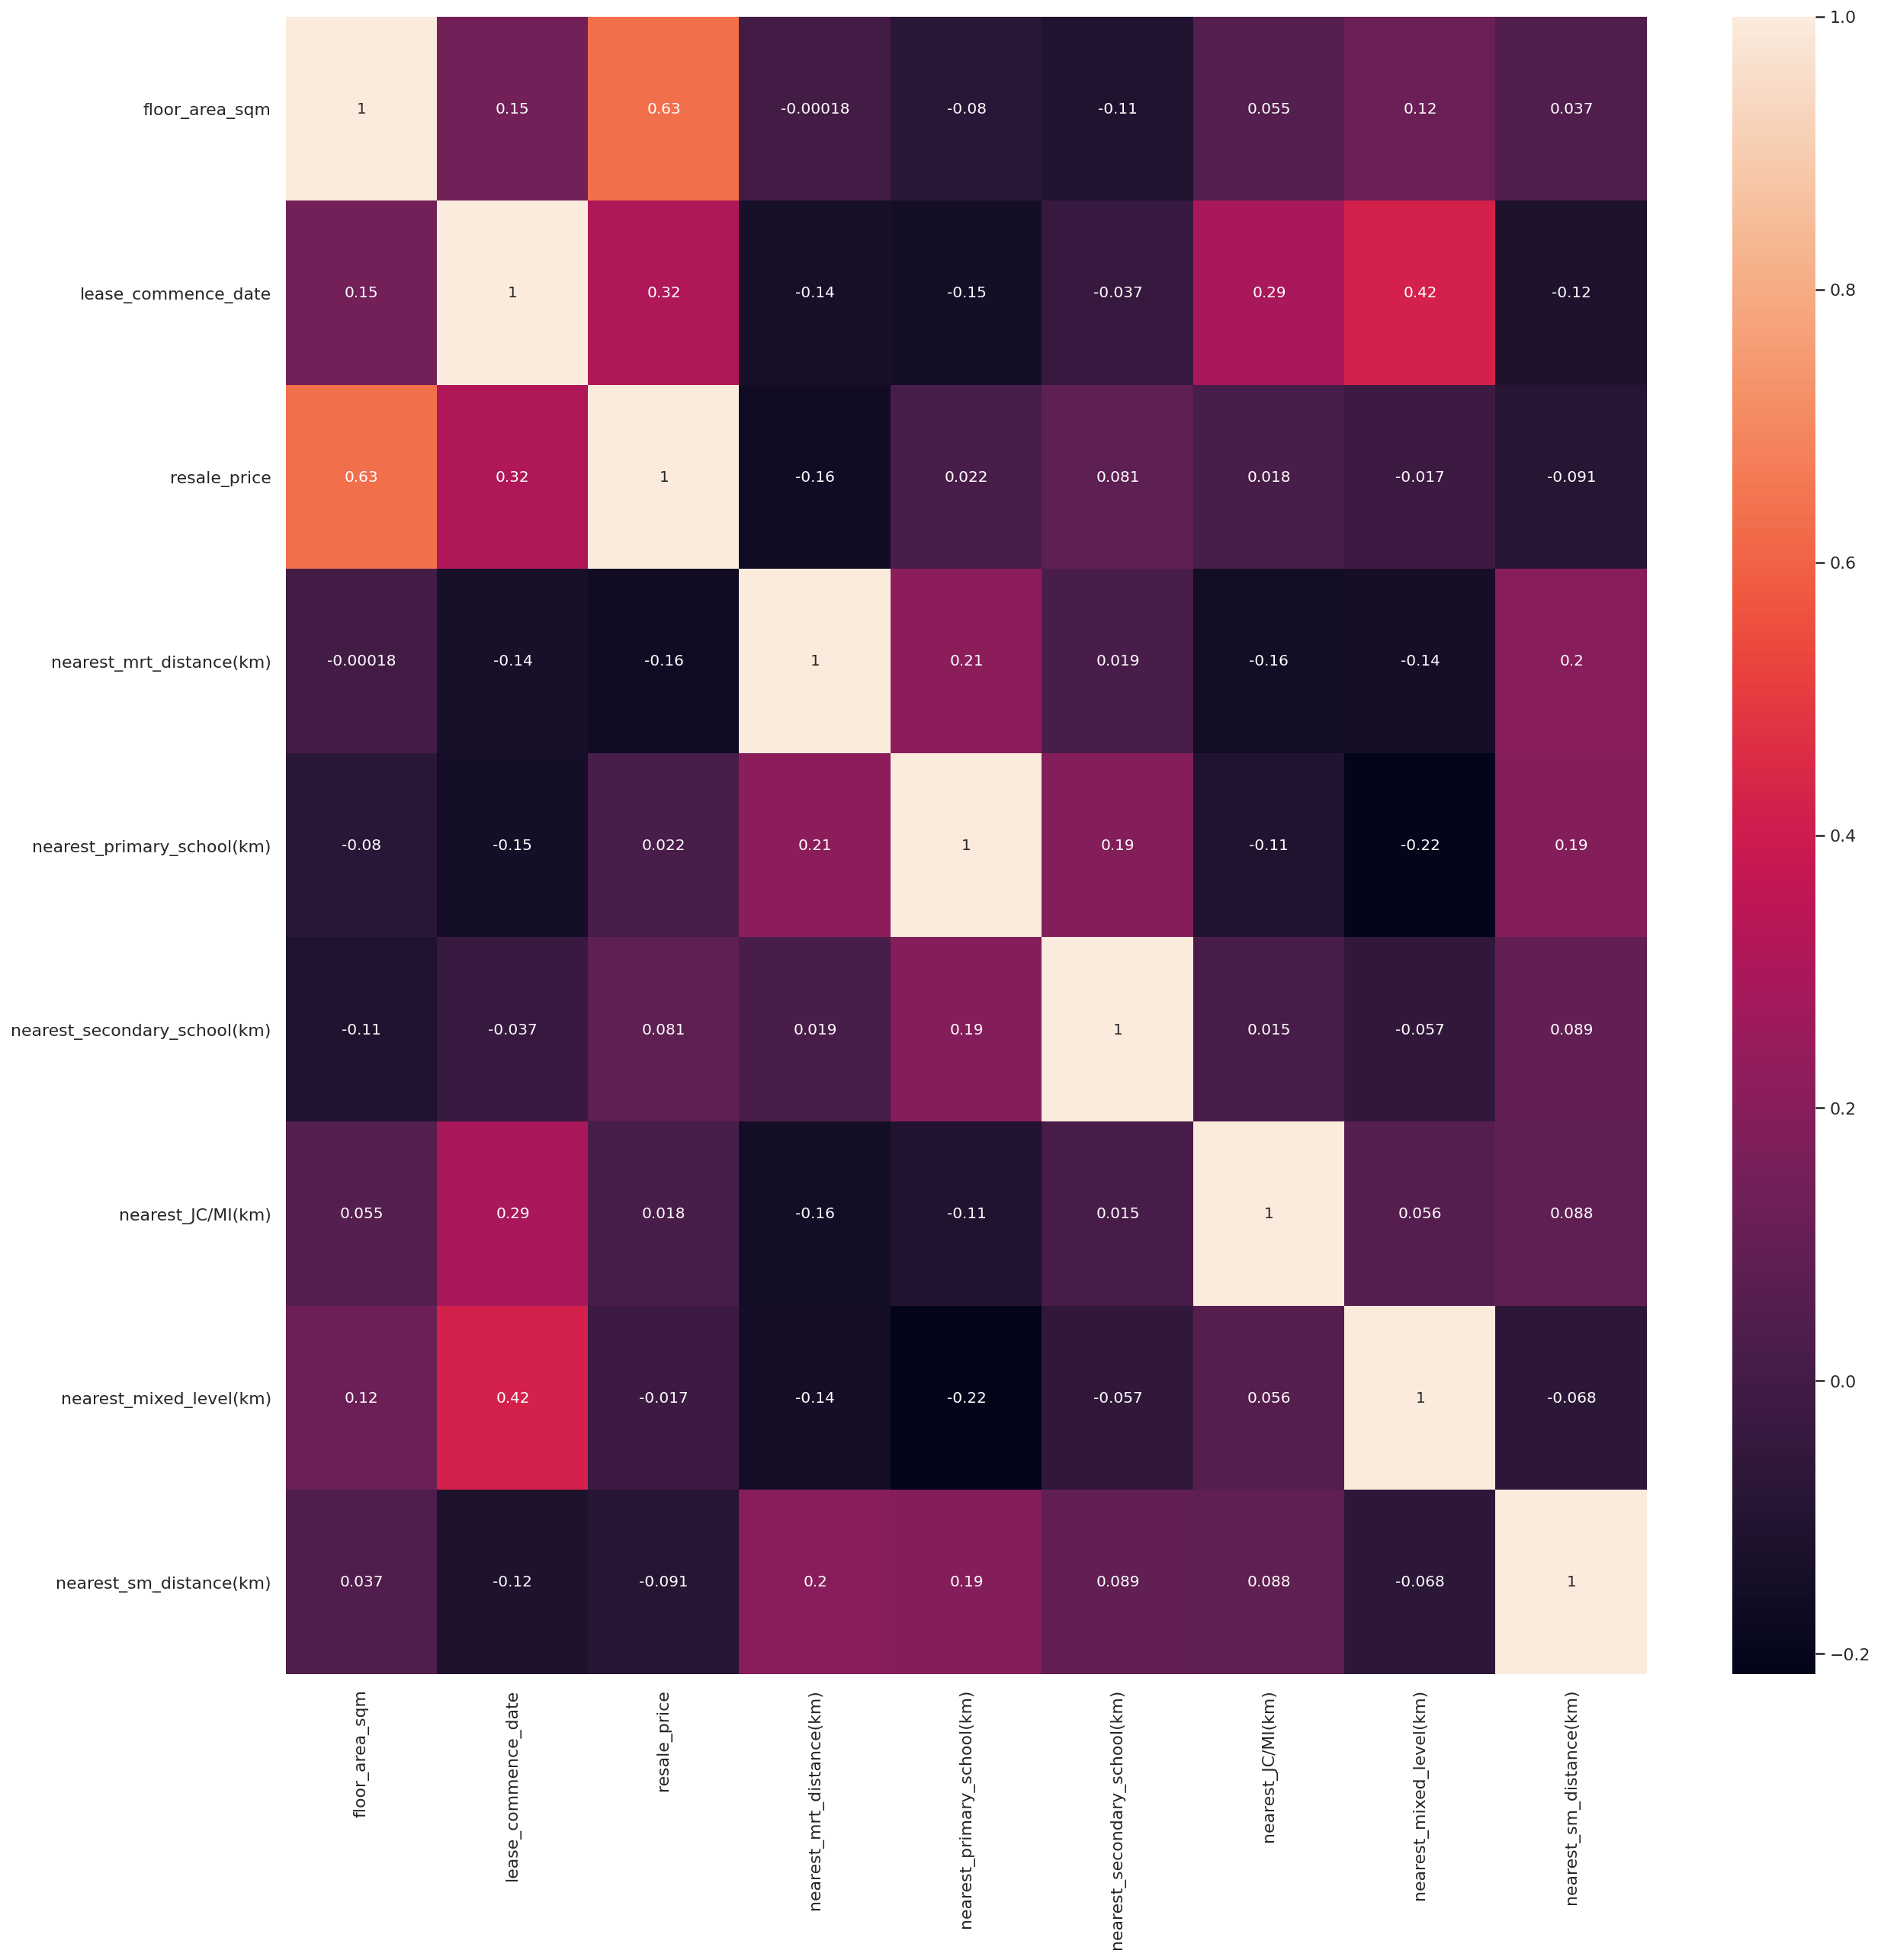

In [12]:
# Correlation Matrix Heatmap
corrmat = df.corr()
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(corrmat, annot=True);

In [13]:
# Ranking the correlated features
cols = corrmat.nlargest(10, 'resale_price')['resale_price'].index
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,resale_price
1,floor_area_sqm
2,lease_commence_date
3,nearest_secondary_school(km)
4,nearest_primary_school(km)
5,nearest_JC/MI(km)
6,nearest_mixed_level(km)
7,nearest_sm_distance(km)
8,nearest_mrt_distance(km)


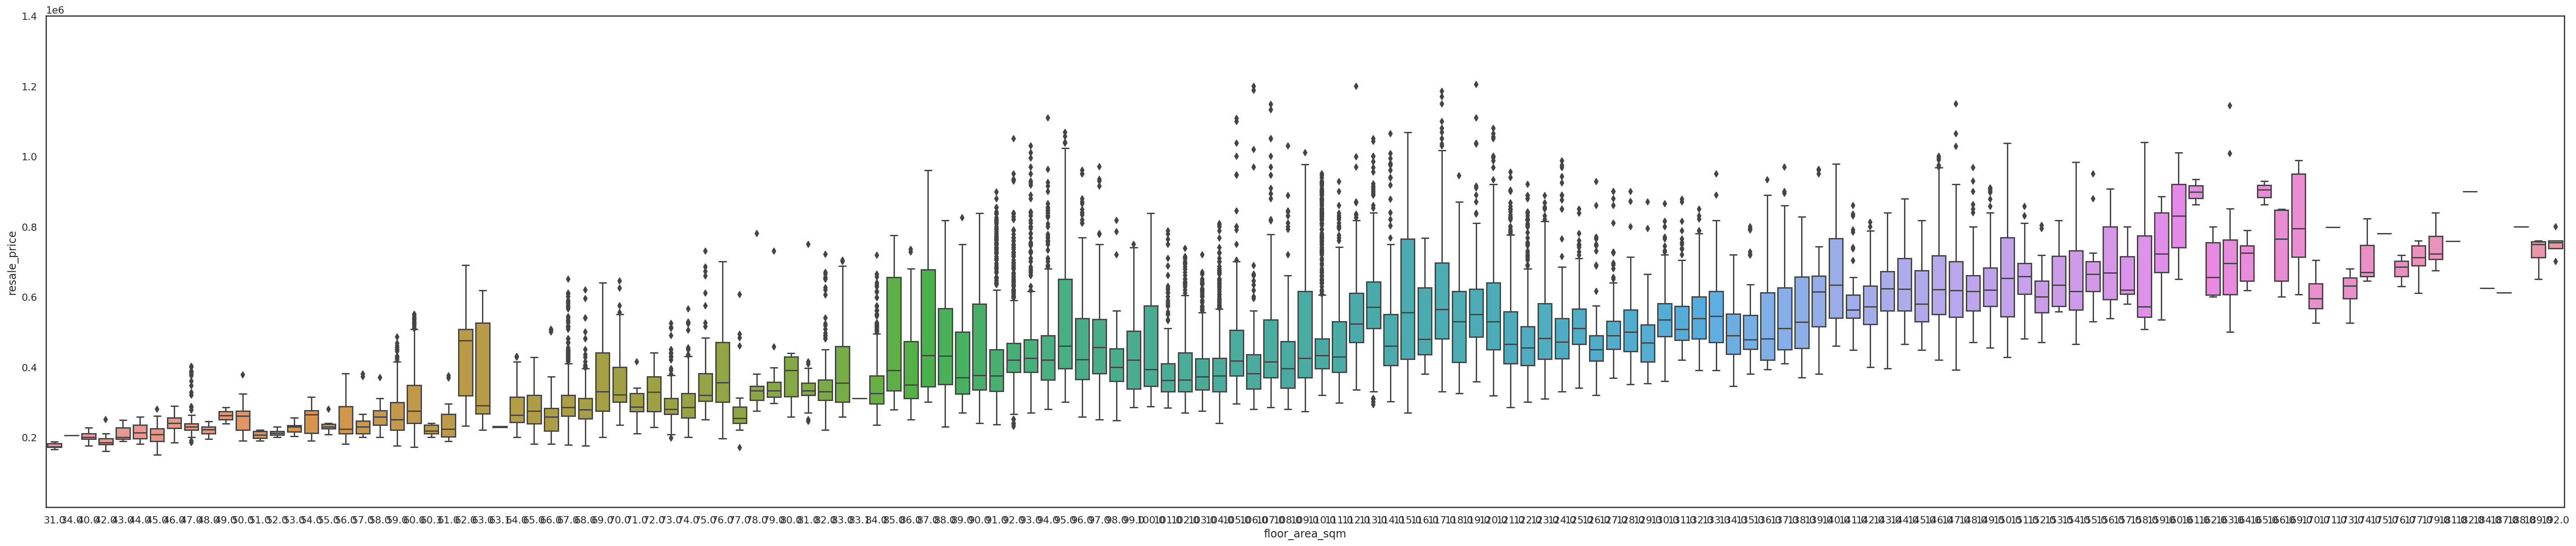

In [14]:
# floor_area_sqm vs resale_price using box plot
var = 'floor_area_sqm'
data = pd.concat([df['resale_price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(50, 10))
fig = sns.boxplot(x=var, y="resale_price", data=data)
fig.axis(ymin=1000, ymax=1400000);
# positive correlation: higher price for larger floor area

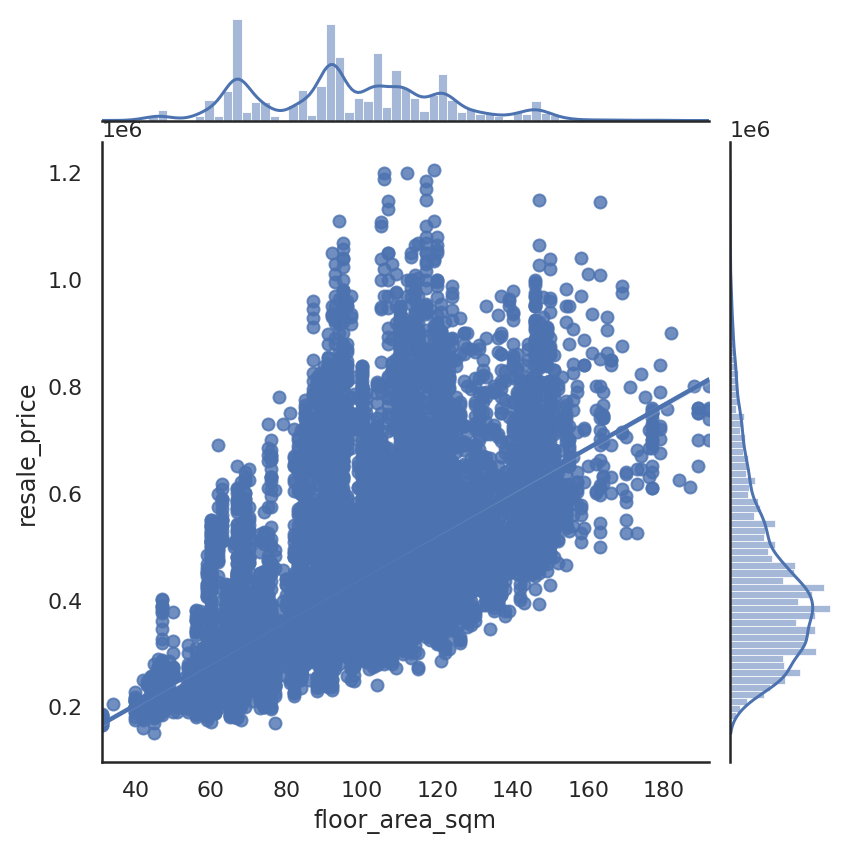

In [15]:
# floor_area_sqm vs resale_price using joint plot
sns.jointplot(x=df['floor_area_sqm'], y=df['resale_price'], kind='reg')
# cannot see pearson r score
# no need to remove any outlier here i think

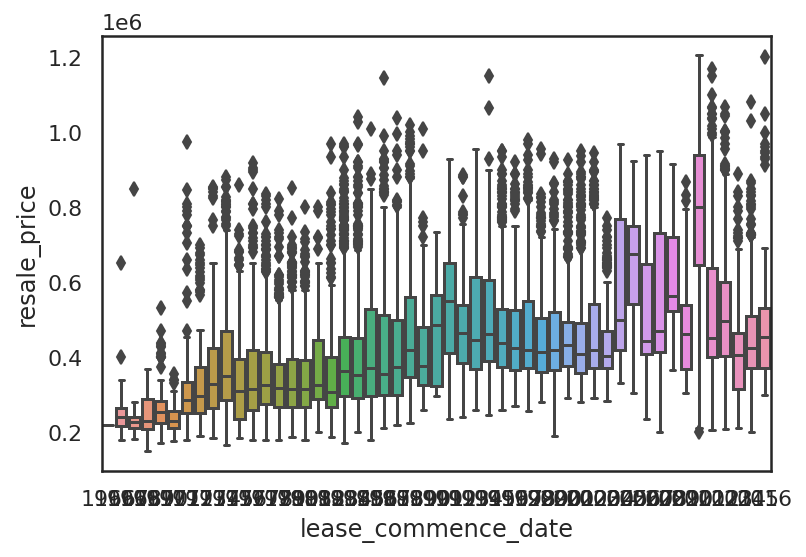

In [16]:
# lease_commence_date vs resale_price using boxplot
sns.boxplot(x=df['lease_commence_date'], y=df['resale_price'])
# increasing through the years? thinking it is more of a categorical variable than numerical?

# Fix Skewness


 mu = 12.92 and sigma = 0.34



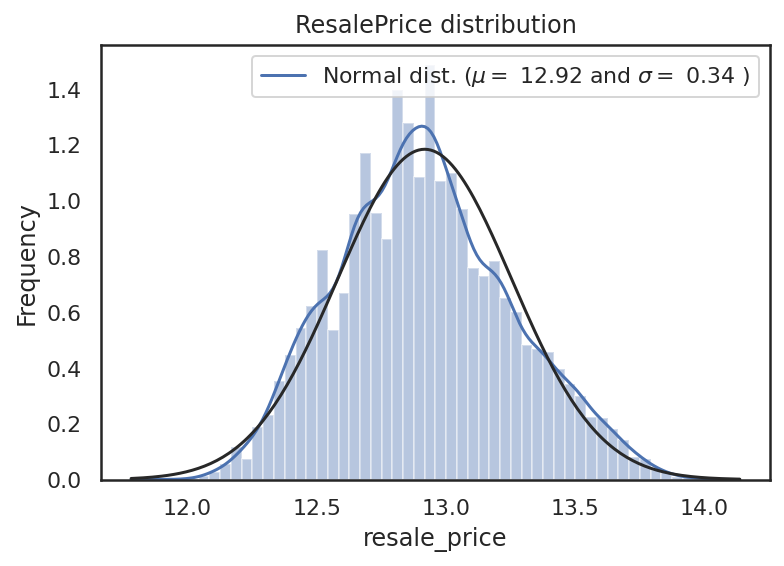

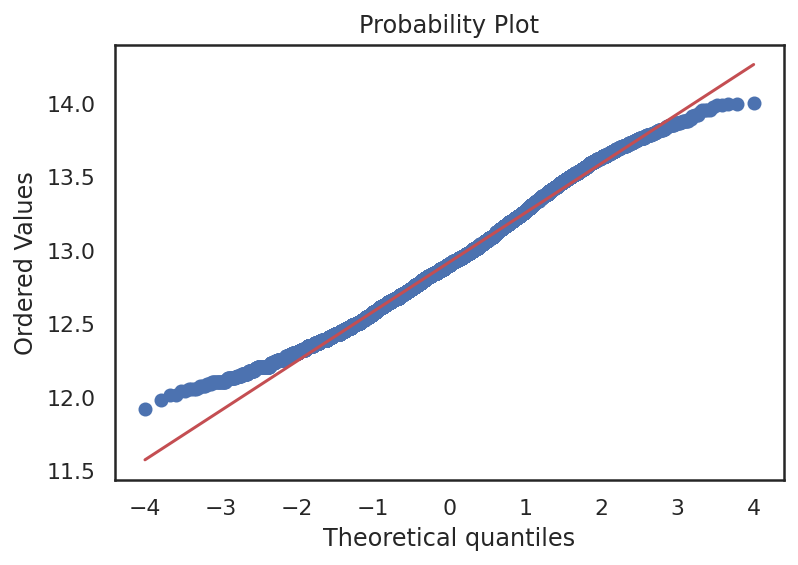

Skewness: 0.233683
Kurtosis: -0.301898


In [17]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["resale_price"] = np.log1p(df["resale_price"])
# use log1p instead of log because more accurate for smaller numbers of x i think, but shouldn't be an issue in this case
# https://stackoverflow.com/questions/49538185/what-is-the-purpose-of-numpy-log1p

#Check the new distribution 
sns.distplot(df["resale_price"], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df["resale_price"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ResalePrice distribution')

fig = plt.figure()
res = stats.probplot(df["resale_price"], plot=plt)
plt.show()

# y_train = df.resale_price.values

print("Skewness: %f" % df["resale_price"].skew())
print("Kurtosis: %f" % df["resale_price"].kurt())
# decreased as compared to the first plot

In [18]:
df['resale_price']

0        12.506181
1        12.594734
2        12.506181
3        12.345839
4        12.478010
           ...    
22181    13.270785
22182    13.244583
22183    13.358227
22184    13.578381
22185    13.334245
Name: resale_price, Length: 22186, dtype: float64

In [19]:
numeric_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
nearest_sm_distance(km),2.189616
nearest_primary_school(km),1.836057
nearest_secondary_school(km),1.670940
nearest_mrt_distance(km),1.076184
nearest_JC/MI(km),0.245989


In [20]:
# Apply box cox on skewed numerical features
skewness = skewness[abs(skewness) > 0.75]
# doesn't this mean to take only features with values more than 0.75? above values < 0.75 but it still indicate those values

print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]-1))
from scipy.special import boxcox1p
# A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape. 
# https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if feat != 'resale_price':
        # print(feat)
        df[feat] = boxcox1p(df[feat], lam)
        df[feat] += 1

There are 8 skewed numerical features to Box Cox transform


# Standardisation

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

num_var = []
for col in df.select_dtypes(include=['int64','float64']).columns:
    num_var.append(col)

transformed = scaler.fit_transform(df[df.select_dtypes(include=['int64','float64']).columns])

for i, var in enumerate(num_var):
    df[var] = transformed[:,i]
    
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,nearest_mrt_distance(km),nearest_primary_school(km),nearest_secondary_school(km),nearest_JC/MI(km),nearest_mixed_level(km),nearest_sm_distance(km)
count,2.218600e+04,2.218600e+04,2.218600e+04,2.218600e+04,2.218600e+04,2.218600e+04,2.218600e+04,2.218600e+04,2.218600e+04
mean,-1.074123e-15,7.461171e-14,-4.224022e-15,1.983899e-16,3.061796e-17,8.151227e-16,-2.790320e-17,-8.237348e-17,-4.543477e-16
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,-3.928457e+00,-2.164788e+00,-2.966872e+00,-1.887808e+00,-1.748513e+00,-1.895058e+00,-2.509556e+00,-2.506964e+00,-1.945077e+00
25%,-7.750715e-01,-7.910698e-01,-7.189244e-01,-7.923022e-01,-7.652930e-01,-7.581778e-01,-7.566164e-01,-8.344962e-01,-7.068018e-01
50%,-1.843931e-02,-3.246219e-02,-5.688745e-02,-1.195417e-01,-1.385746e-01,-1.403764e-01,1.374085e-01,2.014135e-01,-1.236549e-01
75%,6.661739e-01,7.229201e-01,6.639017e-01,6.474311e-01,5.764196e-01,5.928717e-01,8.060585e-01,8.449143e-01,5.648733e-01
max,2.894145e+00,1.625163e+00,3.214888e+00,4.997341e+00,7.751356e+00,6.710156e+00,2.045849e+00,2.078815e+00,9.650282e+00


# Convert categorical variables to numerical

In [22]:
# 1) get_dummies method
# all_data = pd.get_dummies(all_data)
# get_dummies convert categorical variable into dummy/indicator variables e.g. flat_model_Simplified with 0s and 1s
# https://www.w3resource.com/pandas/get_dummies.php
# lightgbm gives the best rmse when using get_dummies method

# 2) label encoder method
from sklearn import preprocessing
for column in df.columns:
    if df[column].dtype == type(object):
#         print(column)
        le = preprocessing.LabelEncoder()
        df[column] = le.fit_transform(df[column])
# supposedly used for labels y and not x
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# gradient boost gives the best rmse when using label encoder
# overall best rmse when comparing the two methods as well

# Split into Train and Test Datasets

In [23]:
y = df['resale_price']
X = df.drop(['resale_price'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13311, 13) (8875, 13) (13311,) (8875,)


# Regression Models

In [24]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor

In [25]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=5))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=5)) # almost exactly the same as lasso. consistently top in error
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5) # too much computational time
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, random_state=5)
dtr = DecisionTreeRegressor(max_depth=10, random_state=5)

# Cross Validation

In [26]:
# Train set evaluation metrics with cross-validation
n_folds = 2
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)

def MAE_cv(model):
    MAE = -cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv = kf)
    return MAE
    
def MSE_cv(model):
    MSE = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv = kf)
    return MSE

def RMSE_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def r2_cv(model):
    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv = kf)
    return r2

# full list of scorers
# from sklearn.metrics import SCORERS
# sorted(SCORERS.keys())
# no adjusted r2

# Evaluate Train Data with Cross Validation

dtr: 0.31219723549169887
lasso: 0.4385834602916211
gboost: 0.1955408334669479
lgb: 0.24836398249658712


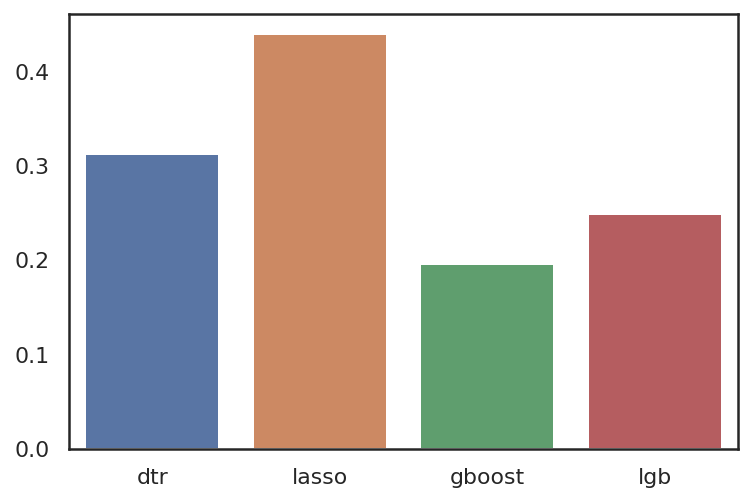

In [27]:
# Root Mean Square Error (RMSE) Evaluation
models = [dtr, lasso, GBoost, model_lgb]
names = ['dtr', 'lasso', 'gboost', 'lgb']
RMSE_results = []
for i in range(len(models)):
    result = RMSE_cv(models[i]).mean()
    name = names[i]
    RMSE_results.append(result)
    print(name + ': ' + str(result))
sns.barplot(names, RMSE_results)

dtr: 0.9032698662888118
lasso: 0.8090791384773157
gboost: 0.9620510177580391
lgb: 0.9387816430885683


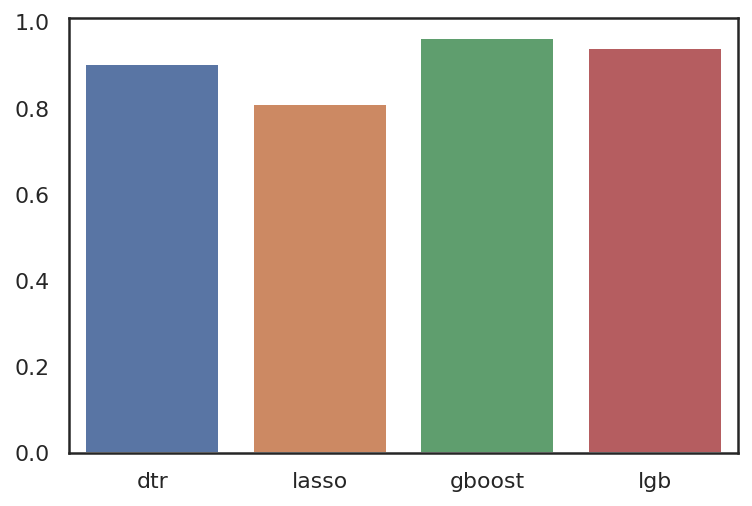

In [28]:
# R2 Evaluation
r2_results = []
for i in range(len(models)):
    result = r2_cv(models[i]).mean()
    name = names[i]
    r2_results.append(result)
    print(name + ': ' + str(result))
sns.barplot(names, r2_results)

# Test data Evaluation

In [29]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

dtr: 0.27069229572791587
lasso: 0.43304269890795083
gboost: 0.1760977754951281
lgb: 0.2385298210628613


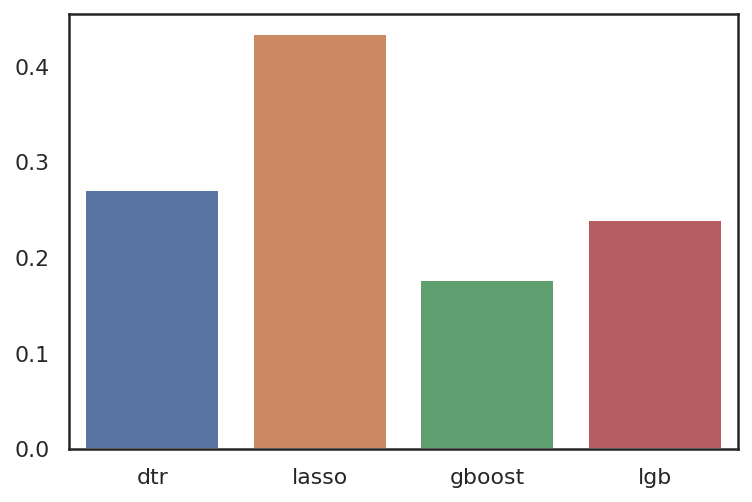

In [30]:
# Root Mean Squared Error (RMSE) Evaluation
RMSE_results = []
for i in range(len(models)):
    model = models[i]
    name = names[i]
    model.fit(X_train, y_train)
    RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    RMSE_results.append(RMSE)
    print(name + ': ' + str(RMSE))
sns.barplot(names, RMSE_results)

dtr: 0.9258238907054664
lasso: 0.8101661302920502
gboost: 0.9686079267562491
lgb: 0.9424032969888767


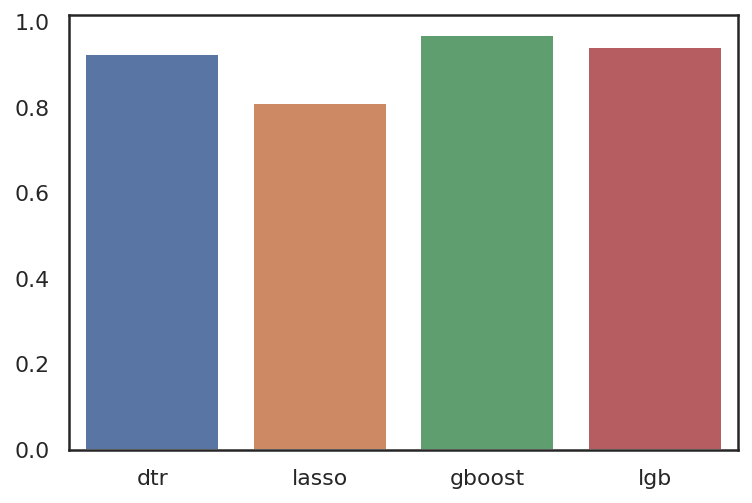

In [31]:
# R2 Evaluation
r2_results = []
adjusted_r2_results = []
p = df.shape[1]
n = y_test.shape[0]

for i in range(len(models)):
    model = models[i]
    name = names[i]
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    adjusted_r2 = 1-(1-r2)*((n-1)/(n-p-1))
    adjusted_r2_results.append(adjusted_r2)
    r2_results.append(r2)
    print(name + ': ' + str(r2))
sns.barplot(names, r2_results)